# Introduction to PyMC3

Before jumping into cooler and more complex models, we are going to try out PyMC3 with some simple regression models. For most of these examples, non-Bayesian methods would be more than appropriate, but we need to start from some basics, so that we can learn how to use the library correctly.

**Outline of this notebook** : 
 
 - Example 1: Linear Regression
 - Exercise 1: first parameter estimation



In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

import statsmodels.api as sm
#import arviz as az
import arviz as az



x = np.linspace(0, 3, 100)
data_t = -1 + 0.5 * x + 0.1 * np.random.randn(1,len(x))
data_outliers = data_t.copy()
data_outliers[:,10] = 0
data_outliers[:,80] = -.5

data_h = -1 + 0.5 * x + x * 0.3 * abs(np.random.randn(1,len(x))) + 0.1 * abs(np.random.randn(1,len(x)))

car_t = np.linspace(0,3, 100)
car_v = 5 * (car_t) + 2 * (np.random.randn(1,len(car_t)))**2



## Example 1: Linear Regression

In a linear regression problem, we are trying to estimate the parameters ($\beta, \alpha$) that best describe the data ($x, y$), assuming those come from a linear approximation, and possibly a noise term $\epsilon$

$ y = \beta x + \alpha + \epsilon $

Imagine we have an instrument that measures temperature at different depths (e.g. temperatures from the surface of a material). We know that the temperature varies linearly with depth but that the slope depends on the humidity of the room. Moreover, the measurement error increases in time and the instrument needs to be replaced when the variance is above XXX . 

We would like to estimate the slope $\beta$ and bias $\alpha$ so that we could estimate the humidity, while making sure the instrument is reliable ($\epsilon$)

### Below the measurements:

[-0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5]


Text(0.5, 1.0, 'Observations')

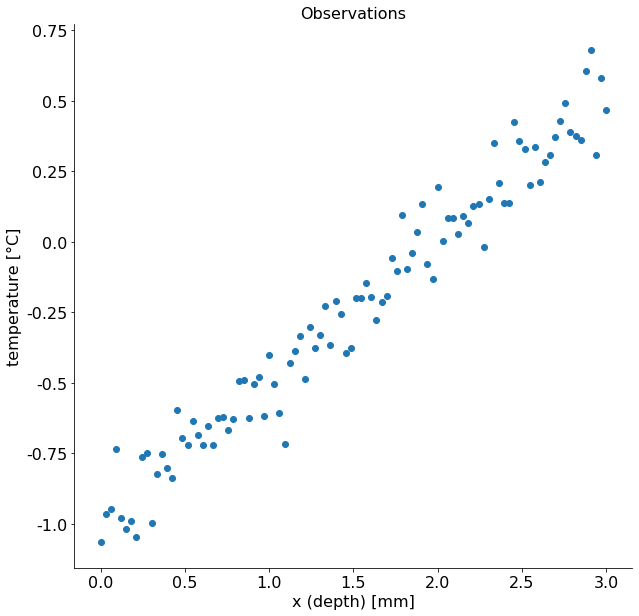

In [52]:
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_t)

print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2303.
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           7.01e-70
Time:                        14:37:24   Log-Likelihood:                 96.990
No. Observations:                 100   AIC:                            -190.0
Df Residuals:                      98   BIC:                            -184.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0001      0.018    -54.368      0.0

Text(0.5, 1.0, 'Observations')

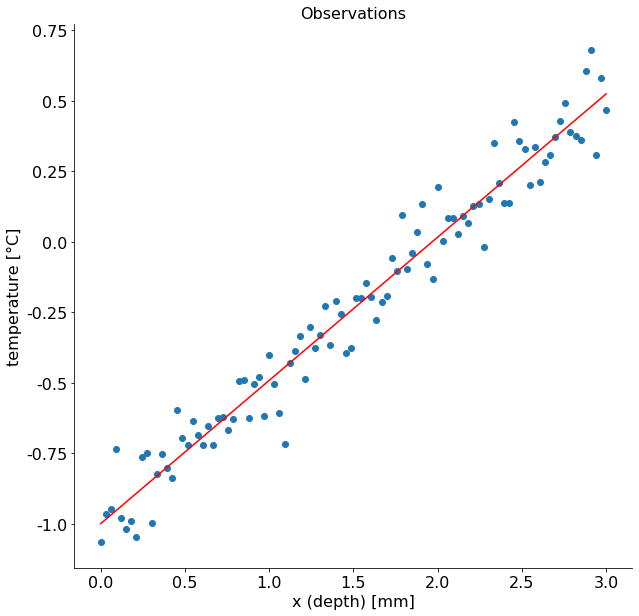

In [53]:
# Results of least square regression 


X=x[:,np.newaxis].copy()
X=sm.add_constant(X)
model = sm.OLS(data_t.T, X)
results = model.fit()
print(results.summary())

y=results.params[0]+results.params[1]*x
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_t)
ax.plot(x,y, 'r')
print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


As we mentioned before, for Bayesian inference we need to first make a full model described by appropriate probability distributions.

**Model**
$ y = \beta x + \alpha + \epsilon $

**Likelihood of the data**

Measures are usually normally distributed around the actual temperature values. 

$ y \sim N ( \beta x + \alpha, \epsilon ) $

**Priors of the parameters**:

  - Slope $\beta$, continuous values, $(-\inf, +\inf)$, we know it is usually between 0 and 1.
  - Bias $\alpha$, continuous values, $(-\inf, +\inf)$, the instrument we know has a bias of around $-1$
  - Variance $\epsilon$, continuous values, $(0, +\inf)$
 
$ \beta \sim N ( 0.5 , 1 ) $  
$ \alpha \sim N ( -1 , 1 ) $  
$ \epsilon \sim Gamma ( 1 , 1 ) $  

PyMC3 allows the user to specify the model in a very intuitive way. 



### Priors

Let's see what the priors actually look like

Text(0.5, 1.0, 'Prior epsilon')

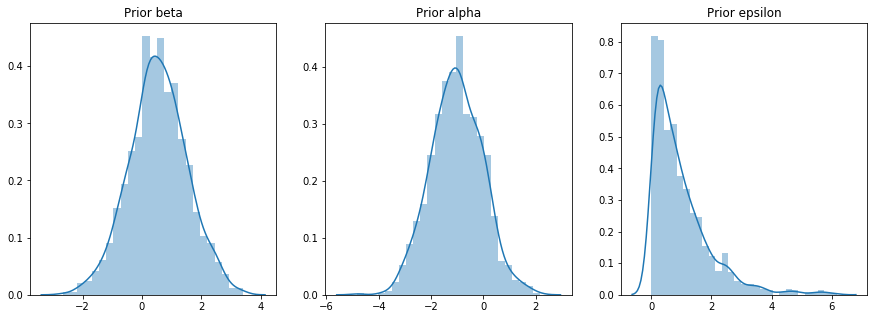

In [54]:
# we simulate 1000 samples from each distribution, numpy.random helps with this as it has many possible pdf
pbeta = np.random.normal(.5,1,1000)
palpha = np.random.normal(-1,1,1000)
pepsilon = np.random.gamma(1,1,1000)

f,ax = plt.subplots(1,3, figsize= (15,5))
sns.distplot(pbeta,ax = ax[0])
sns.distplot(palpha,ax = ax[1])
sns.distplot(pepsilon,ax = ax[2])
ax[0].set_title('Prior beta')
ax[1].set_title('Prior alpha')
ax[2].set_title('Prior epsilon')

### Let's regress the model

In [55]:
# Data
temperature = data_t
depth = x

# PyMC3 Model
with pm.Model() as model:   
    # Priors
    epsilon = pm.Gamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', -1, 1)  
    beta = pm.Normal('beta', .5, 1)  
    # Likelihood
    obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, alpha, epsilon_log__]
100%|██████████| 6000/6000 [00:08<00:00, 682.63it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15ef1b3d30>,
      dtype=object)

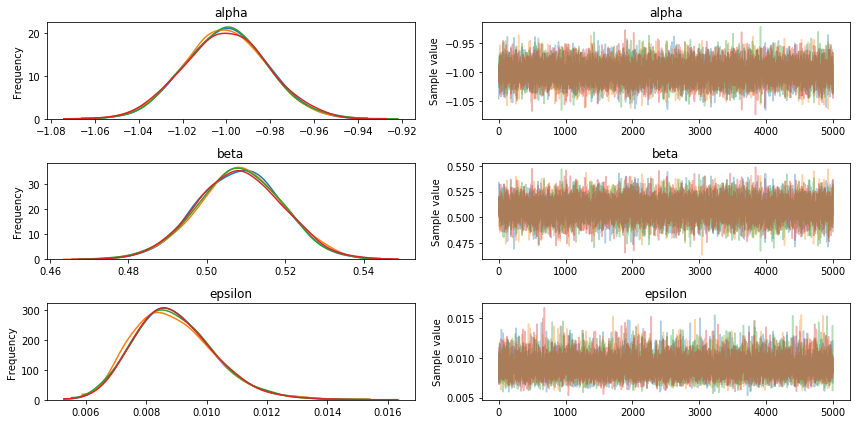

In [56]:
### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

In [57]:
# Descriptive statistic of the posteriors

pm.stats.summary(trace)

/home/viola/.local/lib/python3.6/site-packages/pymc3/stats.py:974: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-1.000266,0.018697,0.000188,-1.036790,-0.963583,8580.273719,1.000067
beta,0.508446,0.010763,0.000111,0.487491,0.529609,8641.548798,1.000120
epsilon,0.008951,0.001332,0.000013,0.006447,0.011514,11982.389884,1.000029


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f15edf8ada0>,
      dtype=object)

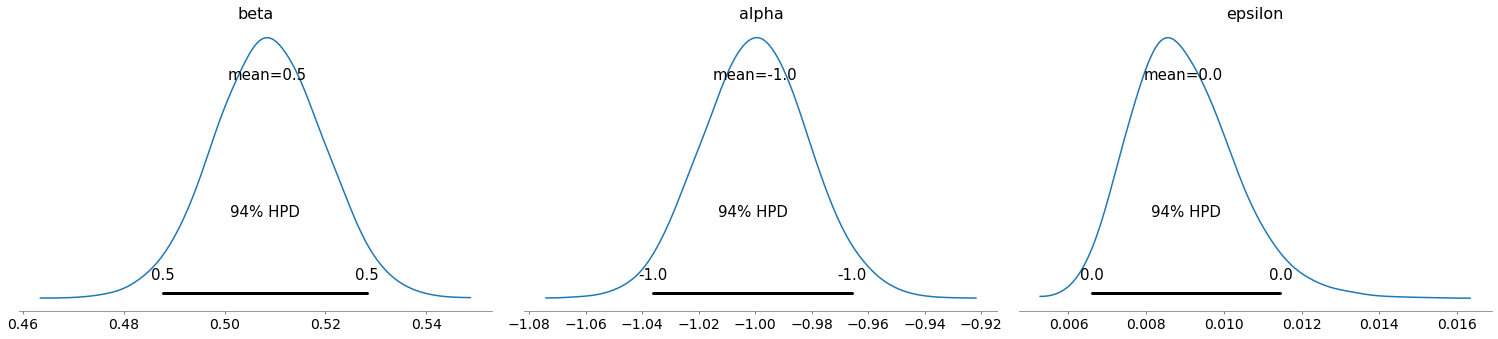

In [58]:
az.plot_posterior(trace, var_names=['beta','alpha', 'epsilon'])

Let's compare priors and posteriors

Text(0.5, 1.0, 'Posterior epsilon')

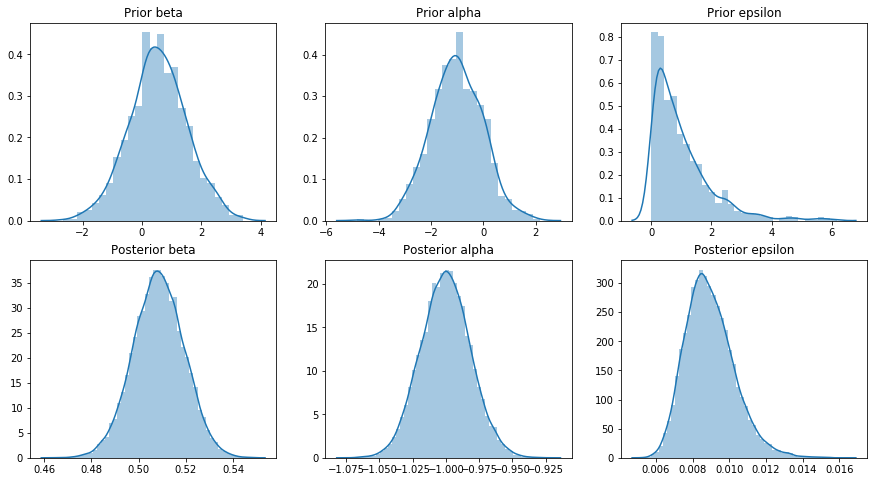

In [59]:
f,ax = plt.subplots(2,3, figsize= (15,8))
sns.distplot(pbeta,ax = ax[0][0])
sns.distplot(palpha,ax = ax[0][1])
sns.distplot(pepsilon,ax = ax[0][2])
ax[0][0].set_title('Prior beta')
ax[0][1].set_title('Prior alpha')
ax[0][2].set_title('Prior epsilon')

sns.distplot(trace['beta'], ax = ax[1][0])
sns.distplot(trace['alpha'], ax = ax[1][1])
sns.distplot(trace['epsilon'], ax = ax[1][2])

ax[1][0].set_title('Posterior beta')
ax[1][1].set_title('Posterior alpha')
ax[1][2].set_title('Posterior epsilon')

Let's compare the actual data with the estimated parameters

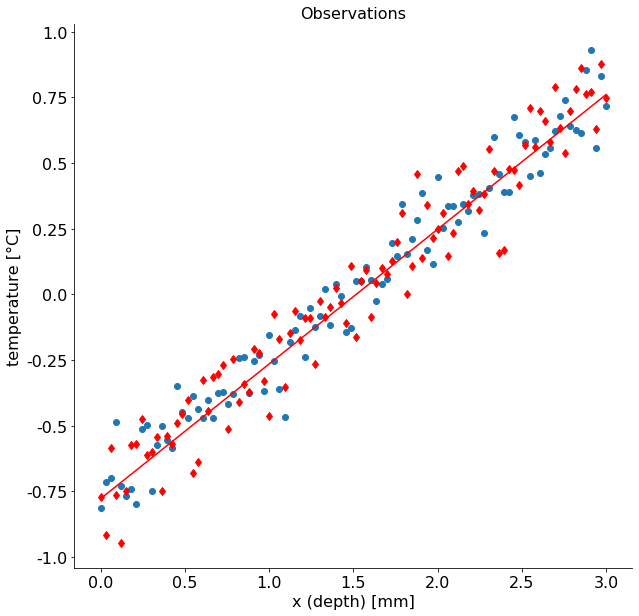

In [60]:
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_t)

ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


# Let's plot the regression line definedby the mean of the posterior
ax.plot(x, -1.028+0.513*x, 'r')


# Let's plot some simulated data that follows the posterior parameters
simulated =  -1.028+0.513*x + np.sqrt(0.0101)*np.random.randn(len(x))
ax.step(x, simulated, 'dr')


# Exercises

Try to estimate the parameters in the following  scenarios ( they might ring a bell )

a) Estimate the actual temperature of the room, having multiple recordings from different termometers
    temperature = (20 , 21, 20.5, 19.8, 19.7, 20.1, 20.6, 18.9)
    
b) What is the number of points Mark is expected to make during the next tournament 3PC ? During the last trainings he scored 18/25, 22/25, 17/25, 21/25.

c) How many absent students should we expect during the next week, given that during the last month, out of 25, 
we recorded 24,23,24,24,24,24,25,25,25,20,19,20,22,21,24,25,25,24,25,24,22,23,20,10,25,24,23,25,20,21 students in the classroom.

### How to specify the PyMC3 Model

1. Choose (pen and paper) the likelihood for the observed data
2. Each likelihood requires some parameters (average, dispersion..)
3. write a model like the one below, remember to specify the observed data array (temperature in this case), and the priors for each parameter
4. Use np.random to simulate the priors, this helps understanding the paramenters you are using and whether they are appropriate

```
with pm.Model() as model:   
    # Priors
    epsilon = pm.Gamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', -1, 1)  
    # Likelihood
    obs = pm.Normal("obs", mu = alpha, sd = np.sqrt(epsilon), observed = temperature )
```

Generate the posteriors, for now ignore what this bit of code does, but use it to obtain the trace
```
SAMPLES = 5000
BURNIN = 1000
CHAINS ) 4
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=CHAINS)

```

trace['parameter-name'] retrieves the array for the posterior of the parameter

## Exercise a

Try to estimate the parameters in the following  scenarios ( they might ring a bell )

a) Estimate the actual temperature of the room, having multiple recordings from different termometers

In [61]:
# Solve Exercise 1a here
temperature = [20 , 21, 20.5, 19.8, 19.7, 20.1, 20.6, 18.9, ]

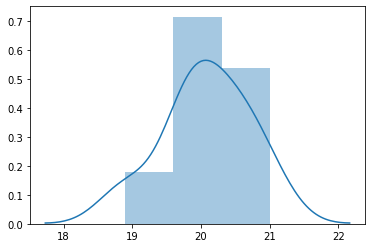

In [62]:
# Plot the data 
sns.distplot(temperature)

In [63]:

# Build the model, remember the definition in PyMC3
# with pm.Model() as model_name: ...
with pm.Model() as model:   
    # Priors
    epsilon = pm.Gamma ('epsilon',1,1)  
    t = pm.Normal('t', 18, 5)  
    # Likelihood
    obs = pm.Normal("obs", mu = t, sd = np.sqrt(epsilon), observed = temperature )


In [64]:
# Evaluate the posterior
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [t, epsilon_log__]
100%|██████████| 6000/6000 [00:03<00:00, 1617.71it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f160368fdd8>,
      dtype=object)

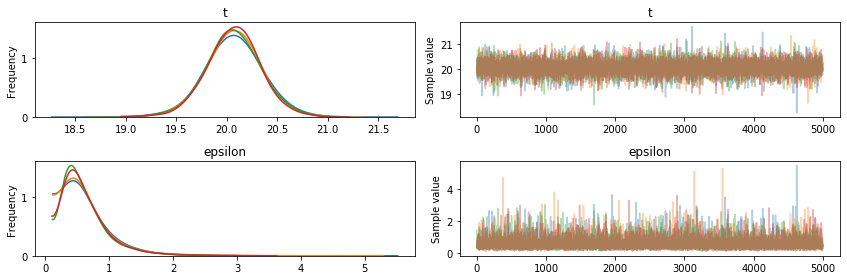

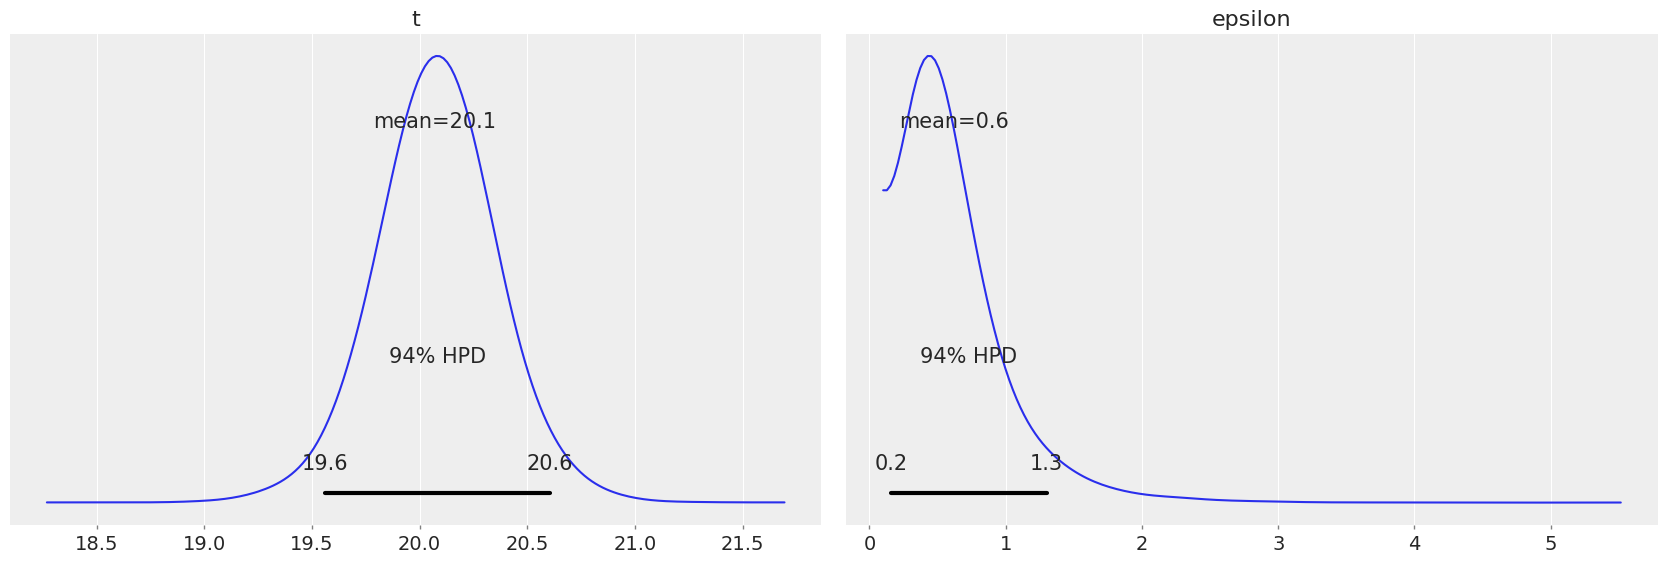

In [65]:
# What can we say on the posterior? Show the summary statistics and some plot
pm.traceplot(trace)


az.style.use('arviz-darkgrid')
az.plot_posterior(trace, var_names=['t', 'epsilon'])

## Exercise b

b) What is the number of points Mark is expected to make during the next tournament 3PC ? During the last trainings he scored 18/25, 22/25, 17/25, 21/25.

Text(0.5, 1.0, 'Prior, Beta(10,5)')

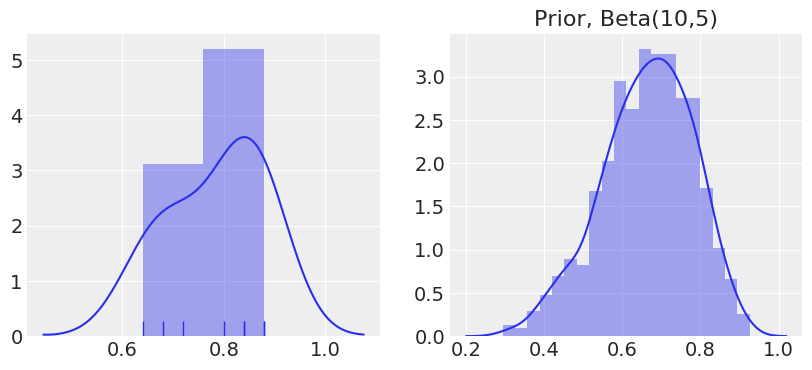

In [66]:
# Solve Exercise 1b here

N = 25
z = [18,22,17,21,22,16,20,21]
pmade = np.array(z)/N


prior = np.random.beta(10,5,1000)
f,ax = plt.subplots(1,2, figsize = (10,4))
sns.distplot(pmade, ax = ax[0], rug = True)
sns.distplot(prior, ax = ax[1])
plt.title('Prior, Beta(10,5)')

In [67]:
with pm.Model() as model:   
    # Priors
    p = pm.Beta('p', 10, 5)  
    # Likelihood
    obs = pm.Bernoulli("obs", p = p, observed = pmade )

In [68]:
# Evaluate the posterior
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p_logodds__]
100%|██████████| 6000/6000 [00:48<00:00, 122.52it/s]
The number of effective samples is smaller than 10% for some parameters.


In [69]:
with model:
    step = pm.NUTS()
    trace = pm.sample(5000, tune=1000, step=step, cores=1)

Sequential sampling (2 chains in 1 job)
NUTS: [p_logodds__]
100%|██████████| 6000/6000 [02:51<00:00, 34.92it/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1603b9fb00>,
      dtype=object)

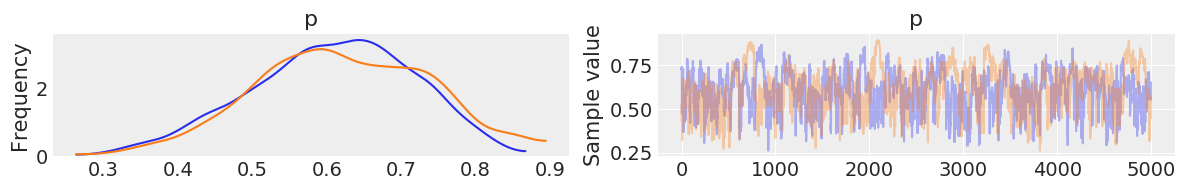

In [70]:
pm.traceplot(trace)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f15ed48b128>],
      dtype=object)

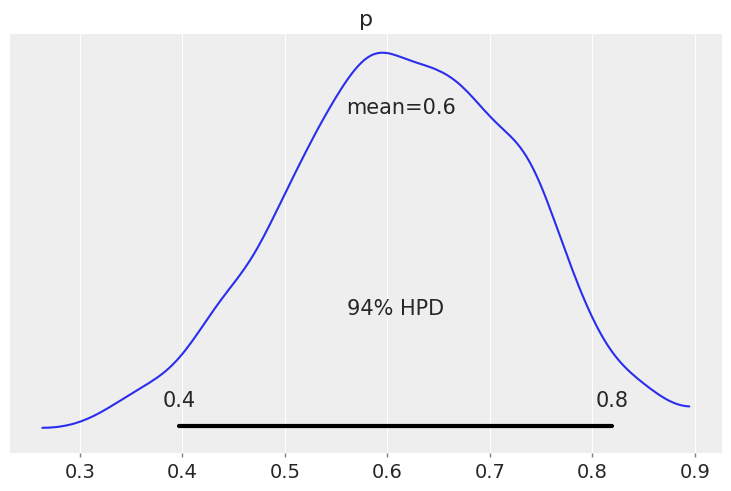

In [71]:

az.style.use('arviz-darkgrid')
az.plot_posterior(trace, var_names=['p'])

## Exercise c

c) How many absent students should we expect during the next week, given that during the last month, out of 25, 
we recorded 24,23,24,24,24,24,25,25,25,20,19,20,22,21,24,25,25,24,25,24,22,23,20,10,25,24,23,25,20,21 students in the classroom.


Text(0.5, 1.0, 'Prior, Beta(10,5)')

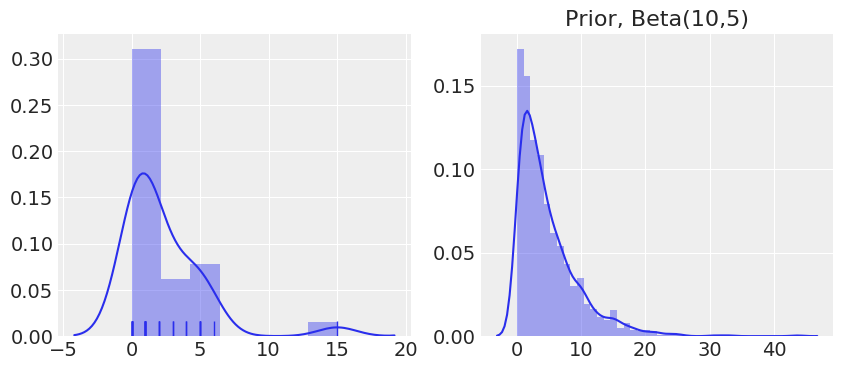

In [72]:
# Solve Exercise 1c here

present = [24,23,24,24,24,24,25,25,25,20,19,20,22,21,24,25,25,24,25,24,22,23,20,10,25,24,23,25,20,21]
absent = 25-np.array(present)

prior = np.random.gamma(1,5,1000)
f,ax = plt.subplots(1,2, figsize = (10,4))
sns.distplot(absent, ax = ax[0], rug = True)
sns.distplot(prior, ax = ax[1])
plt.title('Prior, Beta(10,5)')

In [73]:
with pm.Model() as model:   
    # Priors
    l = pm.Gamma('l', 1, 5)  
    # Likelihood
    obs = pm.Poisson("obs", mu = l, observed = absent )

SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [l_log__]
100%|██████████| 6000/6000 [00:02<00:00, 2098.52it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15ee044128>,
      dtype=object)

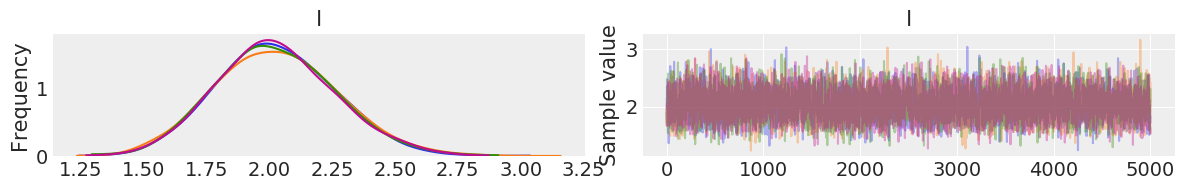

In [74]:
pm.traceplot(trace)

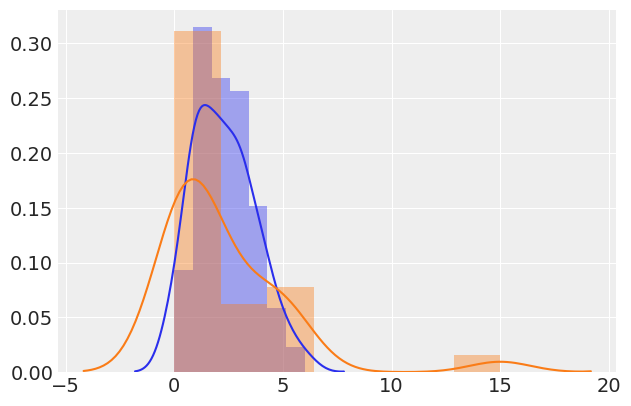

In [75]:
posterior = np.random.poisson(np.average(trace['l']),100)
sns.distplot(posterior)
sns.distplot(absent)